In [10]:
###### CS170 HEADER
"""
Chris Buonocore
904587506
Outlier detection for overvalued and undervalued stocks (done relatively).
"""

%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mp
import matplotlib.pyplot as plt
import scipy.linalg.interpolative as sli
import matplotlib.cm as cm
import seaborn as sns
import pandas as pd
import numpy.linalg as LA
import math
import os
import gc

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm

import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import griddata
from scipy import interpolate
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn import linear_model

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import svm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest

from math import pi

from bokeh.io import show
from bokeh.models import LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.plotting import figure
from datetime import datetime
from dateutil.parser import parse

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction import DictVectorizer


np.set_printoptions(precision=2) #2 decimal places
np.set_printoptions(suppress=True) #remove scientific notation

from datetime import date
from pprint import pprint
from yahoo_finance import Share

"""
module_name, package_name, ClassName, method_name, 
ExceptionName, function_name, GLOBAL_CONSTANT_NAME, 
global_var_name, instance_var_name, function_parameter_name, 
local_var_name
"""

purchase_dir = './sourcingboston/data/redtomato/purchases'
sales_dir = './sourcingboston/data/redtomato/sales'

KEYWORD = "McIntosh"

UNIT_CONV = {
    "BG": "Bag",
    "BN": "Bin",
    "CS": "Case",
    "EA": "Each",
    "LB": "Pound",
    "RL": "RL",
    "TH": "TH",
}

def is_csv(f):
    return 'csv'in f

def pfile(f):
    return os.path.join(purchase_dir, f)

def sfile(f):
    return os.path.join(sales_dir, f)

def is_eco(apple):
    return apple[-1] == 'E'

def is_organic(apple):
    return apple[-1] == 'O'

def get_org_name(apple):
    return apple.replace(KEYWORD, "%s ECO" % KEYWORD)

def plot_year_data(rows, dep='year', target='Price per Case ($)', title=None):
    if not title:
        title = "%s vs. %s" % (target, dep)
    fig, ax = plt.subplots()
    fig.set_figheight(9)
    fig.set_figwidth(12)


    # ax.set_xticks([2014, 2015, 2016, 2017, 2018], minor=True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # key gives the group name (i.e. category), data gives the actual values
    for key, data in rows.groupby('Item Description'):
        data.plot(x=dep, y=target, ax=ax, label=key)
    plt.xticks(rotation=90)
    
    plt.ylabel(title, fontsize=16)
    plt.xlabel('Year', fontsize=16)
    plt.legend(loc=9, bbox_to_anchor=(1.2, 1), edgecolor='w')
    plt.title(title, fontsize=20)


sales_files = list(filter(is_csv, os.listdir(sales_dir)))
purchase_files = list(filter(is_csv, os.listdir(purchase_dir)))


print('sales', sales_files)
print('purchases', purchase_files)

# motley_data_file = './stockdata_2017-01-06.csv' #'./stockdata.csv'
print('done')

sales ['Sales Data 2014-2018.csv', 'Sales History 2018.csv', 'Sales History 2015.csv', 'Sales History 2014.csv', 'Sales History 2016.csv', 'Sales History 2017.csv']
purchases ['Pur_History_2018.csv', 'Pur_History_2016.csv', 'Pur_History_2017.csv', 'Pur_History_2015.csv', 'Pur_History_2014.csv', 'Pur_History_2014-2018.csv']
done


In [11]:
def hide_code():
    import os
    uid = os.urandom(8).encode("hex")
    html = """<div id="%s"></div>
    <script type="text/javascript">
        $(function(){
            var p = $("#%s");
            if (p.length==0) return;

            while (!p.hasClass("cell")) {
                p=p.parent();

                if (p.prop("tagName") =="body") return;
            }
            var cell = p;
            cell.find(".input").addClass("hide-in-slideshow")
        });
    </script>""" % (uid, uid)
    display.display_html(html, raw=True)

In [12]:
# price paid to growers
pdata = pd.read_csv(pfile('Pur_History_2014-2018.csv'))

pdata['year'] = pdata['Receive Date'].map(lambda x: int(x.split('/')[-1]))

pdata = pdata.applymap(lambda x: x.strip() if type(x)==str else x)
data = pdata[(pdata['Rec. UOM'] == 'CS') & (pdata['Received Quantity'] != 0) & (pdata['Actual Inventory Cost'] != 0)]
pdata = data[data['Item Description'].str.contains(KEYWORD)]
pdata['Price per Case ($)'] = pdata['Actual Inventory Cost']/pdata['Received Quantity']
pdata.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1210 entries, 8 to 3690
Data columns (total 22 columns):
Itemcode                     1210 non-null object
Item Description             1210 non-null object
Brand                        1210 non-null object
Pack-size                    1210 non-null object
Vendor ID                    1210 non-null object
Receive Date                 1210 non-null object
PO Number                    1210 non-null int64
PO Line #                    1210 non-null int64
Ordered Quantity             1210 non-null int64
Order UOM                    1210 non-null object
Received Quantity            1210 non-null int64
Rec. UOM                     1210 non-null object
Weight (LB)                  1210 non-null float64
Variance (Quantity)          1210 non-null float64
Estimate Inventory Cost      1210 non-null float64
Actual Inventory Cost        1210 non-null float64
Variance (Inventory Cost)    1210 non-null float64
Estimate Add-on Cost         1210 non-null

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
len(set(pdata['Itemcode']))

23

<img src="./img/apple_bg.jpg"/>

In [14]:
data_year = pdata.reset_index().groupby(['year', 'Item Description'], as_index=False).mean()
# data_year[:]
data_year.to_csv('yearly_mcintosh.csv')

## Overview of the Data

* Datasets for RedTomato Sales over 2014-2018, these were on a yearly basis.
* Datasets for RedTomato Purchases over 2014-2018, these were broken down to the particular day.



## Questions we sought to Solve

* How has our price paid to growers changed over time?
* How has our delivered price changed over time?
* Does eco* (organic) actually provide a price premium?
* How do trucking (and add-on) costs change over time?


## Challenges

* Over 750 different Item Varieties / SKU's Purchased in this Range

* Many apples were only purchased in 1-2 years and not each year, making some trend analysis difficult.

* Variety of different Packaging Units for Apples - Cases, Bags, Pounds, etc.

## It Starts with a Single Apple

In [15]:
def plot_apple(pdata):
    plt.figure(figsize=(16,9))
    app_14 = pdata[pdata['Itemcode'] == 'APP14']
    x = app_14['Receive Date']
    y = app_14['Price per Case ($)']
    plt.plot_date(x, y, 'b-')
    plt.xticks(rotation=90)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
    plt.title('APP14 (Macintosh) - Price/Case', fontsize=20)
    plt.xlabel('Purchase Date', fontsize=16)
    plt.ylabel('Case Price ($)', fontsize=16)
    plt.show()


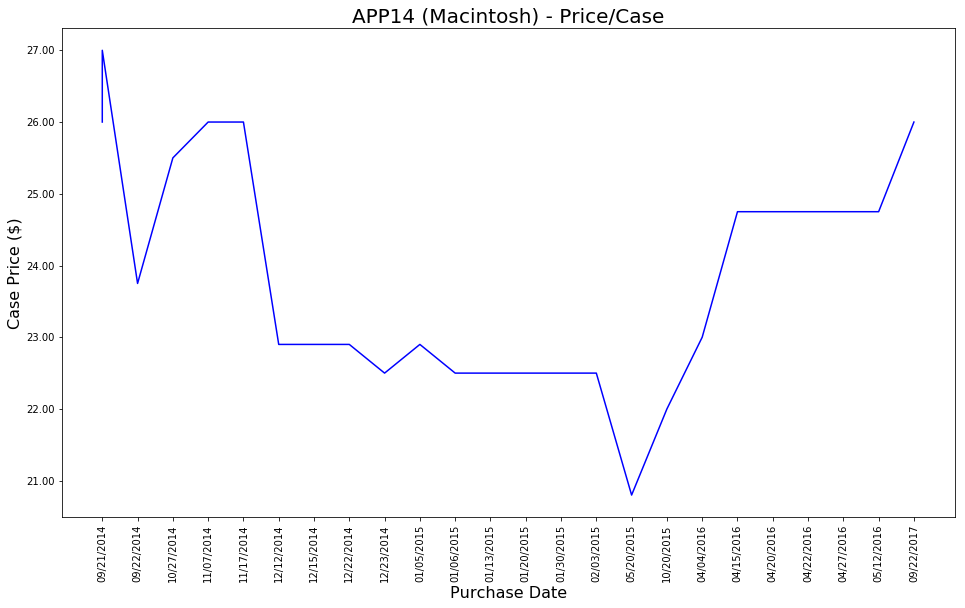

In [16]:
plot_apple(pdata)

## Then it gets broader

* ECO and their non-ECO Counterparts

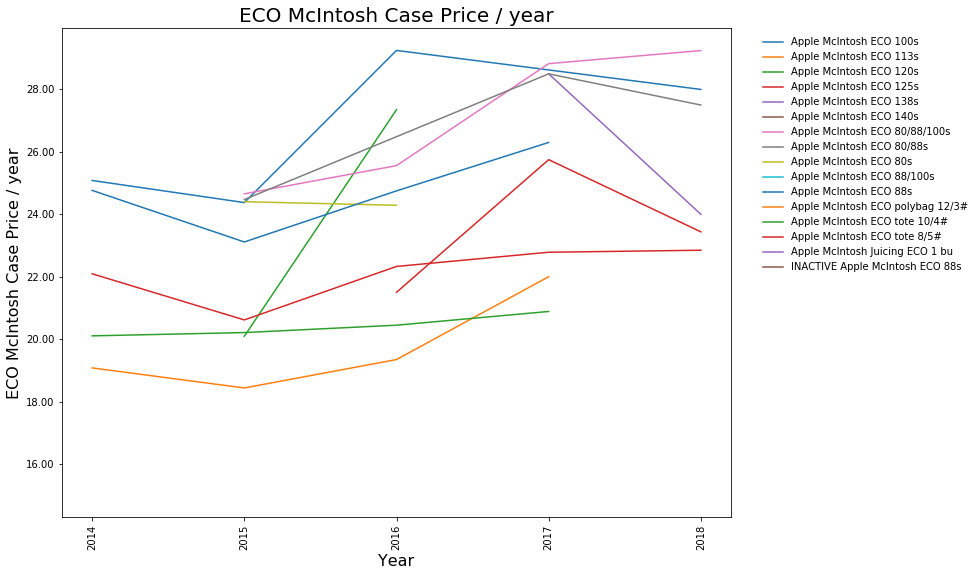

In [17]:
org = data_year[data_year['Item Description'].str.contains('ECO')]
plot_year_data(org, 'year', 'Price per Case ($)', 'ECO %s Case Price / year' % KEYWORD)

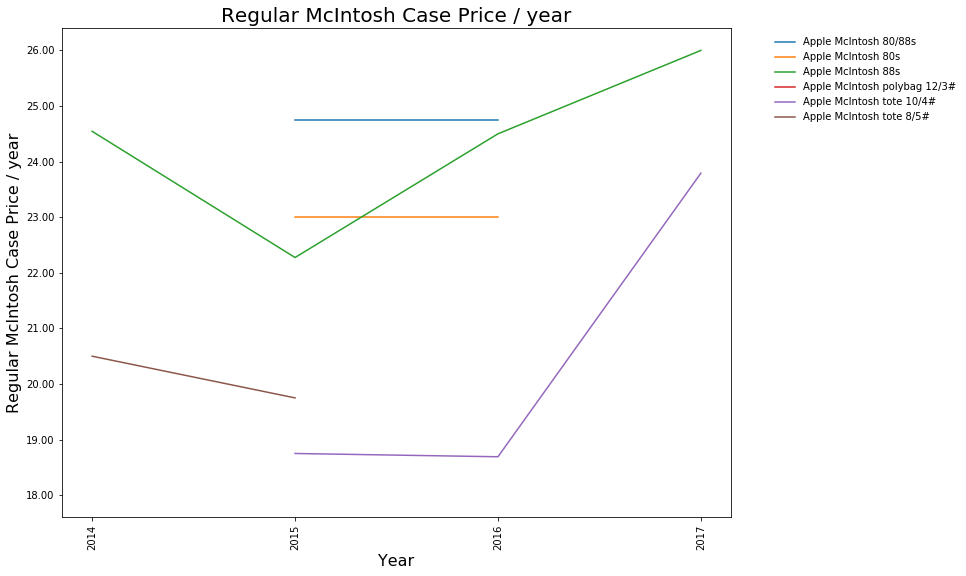

In [18]:
inorg = data_year[~data_year['Item Description'].str.contains('ECO')]
plot_year_data(inorg,'year', 'Price per Case ($)', 'Regular %s Case Price / year' % KEYWORD)

In [39]:
for i, c in enumerate(set(inorg['Item Description'])):
    data_1 = data_year[data_year['Item Description'].str.contains(c)]
    data_2 = data_year[data_year['Item Description'].str.contains(get_org_name(c))]
    # plot_year_data(pd.concat([data_1, data_2]),'year', 'Price per Case ($)', '%s: ECO vs. non-ECO' % c)

<img src="./img/graphs.png"/>

In [20]:
# set(pdata['Rec. UOM'])
data_year.columns.values
# pdata.pct_change()
price_data = pdata[['year', 'Item Description', 'Price per Case ($)']].groupby(['Item Description', 'year']).mean().unstack(1)
price_data = price_data.fillna(axis=1, method='ffill').fillna(axis=1, method='bfill')
price_data.columns = ['2014', '2015', '2016', '2017', '2018']
price_data['$ Change'] = price_data['2018'] - price_data['2014']
price_data = price_data.reset_index().sort_values(['$ Change'], ascending=False)

## But How Did the prices of all these change over time?

In [21]:
price_data.head(5)

,Item Description,2014,2015,2016,2017,2018,$ Change
5,Apple McIntosh ECO 120s,20.090909,20.090909,27.350000,27.350000,27.350000,7.259091
19,Apple McIntosh tote 10/4#,18.750000,18.750000,18.691176,23.791667,23.791667,5.041667
9,Apple McIntosh ECO 80/88/100s,24.656250,24.656250,25.558772,28.826923,29.244898,4.588648
10,Apple McIntosh ECO 80/88s,24.472222,24.472222,24.472222,28.500000,27.500000,3.027778
14,Apple McIntosh ECO polybag 12/3#,19.077922,18.435484,19.345238,22.000000,22.000000,2.922078


In [22]:
def plot_purchase_change(price_data):
    fig = plt.figure(figsize=(16,9))
    plt.xticks(rotation=90)
    plt.title('Apple by Price Change per Case (2014-2018*)')
    plt.xlabel('Apple')
    plt.ylabel('$ Change')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    g = sns.barplot(x="Item Description", y="$ Change", data=price_data)
    print('* using forward/backward fill for missing data')

    for index, row in price_data.reset_index().sort_values(['$ Change'], ascending=False).iterrows():
        g.text(index, row['$ Change'], round(row['$ Change'], 2), color='black', ha="center")

* using forward/backward fill for missing data


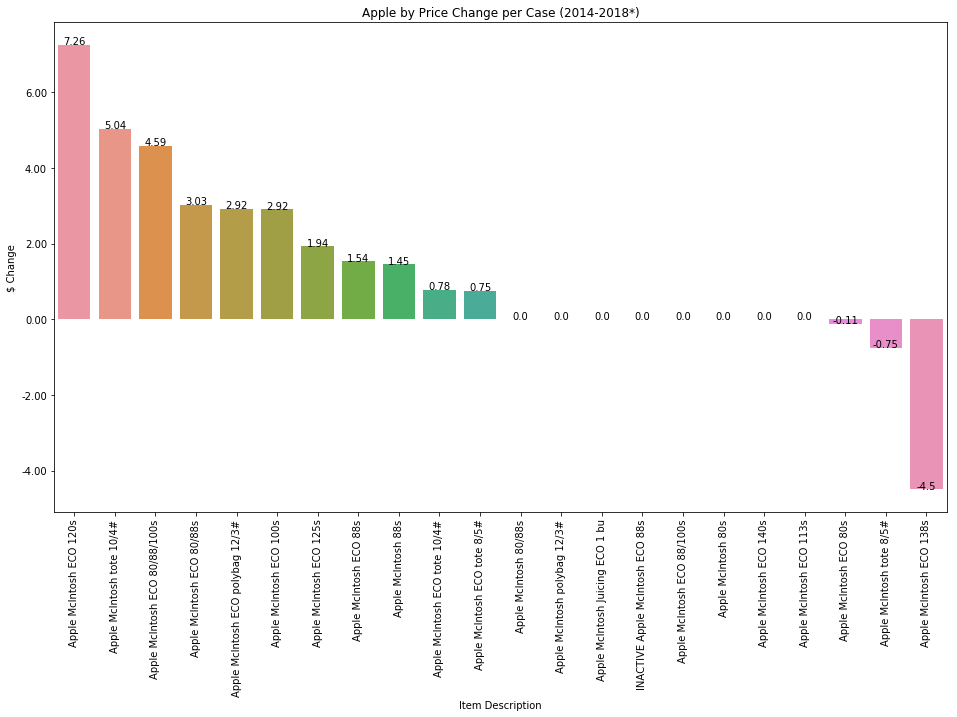

In [23]:
plot_purchase_change(price_data)

In [24]:
# pdata.groupby(['Itemcode',).plot()
pdata['Normalized Add-on Cost'] = pdata['Actual Add-on Cost'] / pdata['Ordered Quantity']
addon_data = pdata[['year', 'Item Description', 'Normalized Add-on Cost']].groupby(['Item Description', 'year']).mean().unstack(1)
addon_data = addon_data.fillna(axis=1, method='ffill').fillna(axis=1, method='bfill')
addon_data.columns = ['2014', '2015', '2016', '2017', '2018']
addon_data['Add-on Change ($)'] = addon_data['2018'] - addon_data['2014']
addon_data = addon_data.reset_index().sort_values(['Add-on Change ($)'], ascending=False)


/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [25]:

def plot_addon_data(addon_data):
    fig = plt.figure(figsize=(16,9))
    plt.xticks(rotation=90)
    plt.title('Apple by Add-on Price Change (2014-2018*)')
    plt.xlabel('Apple')
    plt.ylabel('Add-on Change ($)')
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    g = sns.barplot(x="Item Description", y="Add-on Change ($)", data=addon_data)

    for index, row in addon_data.reset_index().sort_values(['Add-on Change ($)'], ascending=False).iterrows():
        g.text(row.name,row["Add-on Change ($)"], round(row["Add-on Change ($)"],2), color='black', ha="center")

    print('* using forward/backward fill for missing data')
    

* using forward/backward fill for missing data


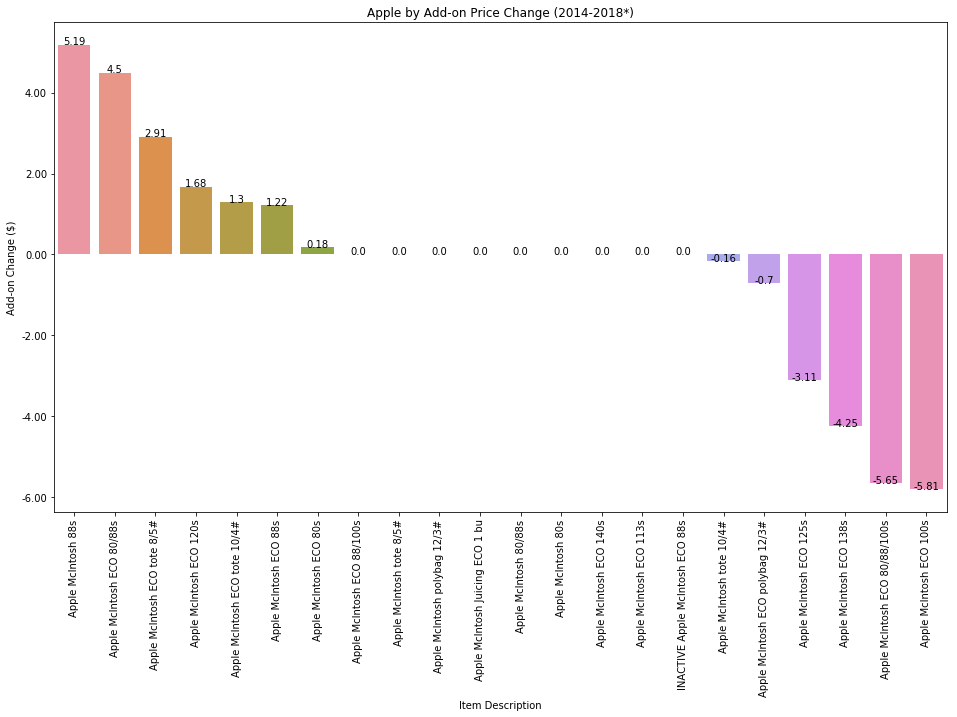

In [26]:
plot_addon_data(addon_data)


## Sales Data

In [27]:
sfiles = sales_files[1:]
print(sfiles)

def read_with_year(f):
    year = os.path.splitext(f)[0].split(' ')[-1]
    d = pd.read_csv(sfile(f))
    d['year'] = int(year)
    return d

sdata = pd.concat([read_with_year(f) for f in sfiles], join="inner")
sdata = sdata.rename(lambda x: x.strip(), axis='columns')

print(sdata.columns.values)
sdata['Item Description'] = sdata['Description']
sdata = sdata.drop(['Description'], axis=1)
sdata.info()

['Sales History 2018.csv', 'Sales History 2015.csv', 'Sales History 2014.csv', 'Sales History 2016.csv', 'Sales History 2017.csv']
['Itemcode' 'Description' 'Item_brand' 'Packsize' 'Number_of_invoices'
 'Quantity_sold' 'Uomid' 'Ave_price_each' 'Ave_cost_each' 'Total_sales'
 'Cost_of_goods_sold' 'Line_gross_profit' 'Gross_profit_per_muom'
 'Profit_percent' 'year']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1863 entries, 0 to 341
Data columns (total 15 columns):
Itemcode                 1863 non-null object
Item_brand               1863 non-null object
Packsize                 1863 non-null object
Number_of_invoices       1863 non-null int64
Quantity_sold            1863 non-null float64
Uomid                    1863 non-null object
Ave_price_each           1863 non-null float64
Ave_cost_each            1863 non-null float64
Total_sales              1863 non-null float64
Cost_of_goods_sold       1863 non-null float64
Line_gross_profit        1863 non-null float64
Gross_profit_per_

In [28]:
sdata_year = sdata.reset_index().groupby(['year', 'Item Description'], as_index=False).mean()

In [29]:
sdata_year = sdata_year[sdata_year['Item Description'].str.contains(KEYWORD)]
print(len(set(sdata_year['Item Description'])))

22


In [30]:
sdata_year.to_csv('sales_%s.csv' % KEYWORD)

## Looking at Sales Data

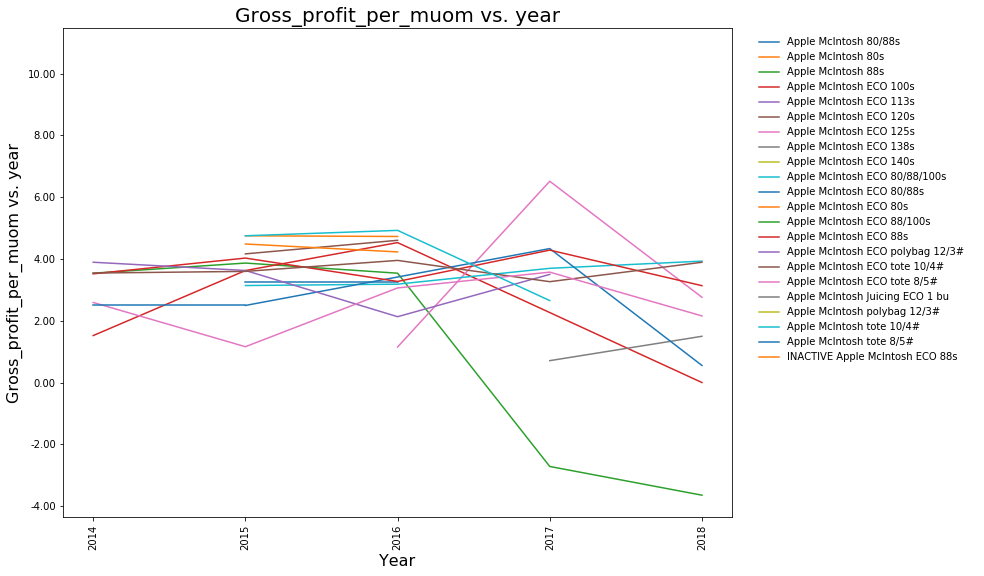

In [31]:
plot_year_data(sdata_year, 'year', 'Gross_profit_per_muom')

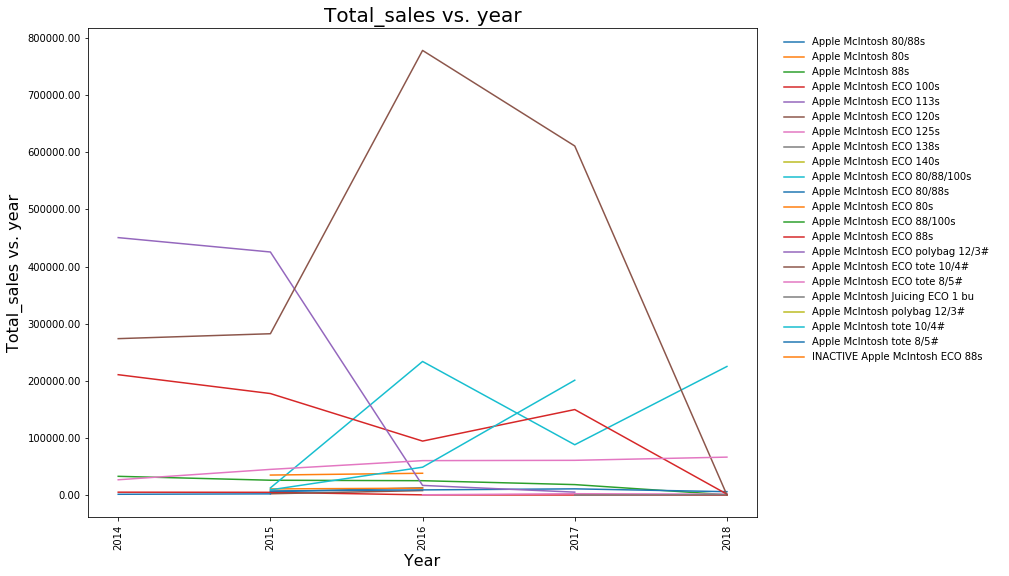

In [32]:
sdata_year_sum = sdata.reset_index().groupby(['year', 'Item Description'], as_index=False).sum()
sdata_year_sum = sdata_year_sum[sdata_year_sum['Item Description'].str.contains(KEYWORD)]
plot_year_data(sdata_year_sum, 'year', 'Total_sales')

In [33]:
data = pdata

data['Year'] = data['year'].astype(str)
data['Month'] = data['Receive Date'].apply(lambda x: x.split('/')[0])

data['YearDay'] = data['Receive Date'].apply(lambda x: parse(x).timetuple().tm_yday)
data = data.set_index('Year')
columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sales = data.copy().reset_index().groupby(['Year', 'Month'])['Actual Inventory Cost'].sum().unstack(level=0).fillna(0).T
sales.columns = columns
purchases = sales.T

def heat_plot(d):
    # sales.dtypes
    plt.figure(figsize=(16,9))
    sns.heatmap(d, linewidths=0, annot=True, fmt=".2f", cmap="Blues")

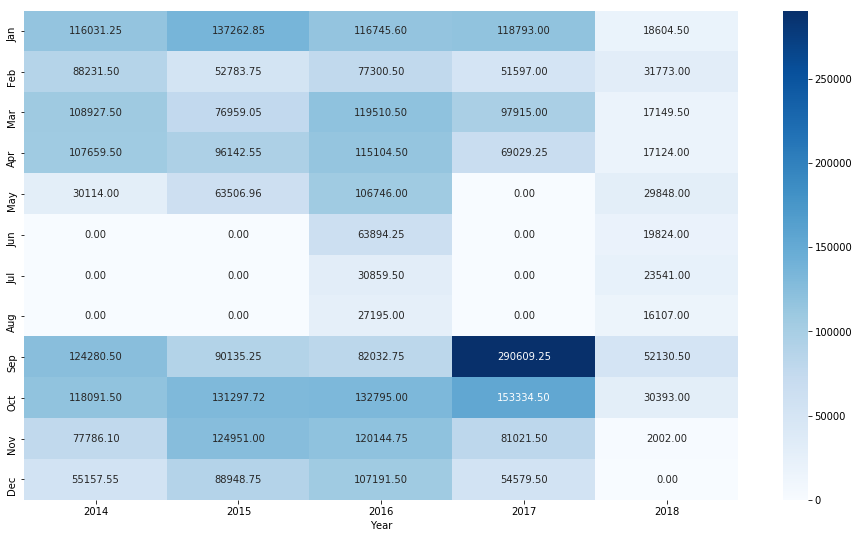

In [34]:
heat_plot(purchases)

In [35]:
# data.columns.values

In [36]:
yearday = data.copy()[['YearDay', 'Item Description']]

In [37]:
def plot_purchase_density(df):
    sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="Item Description", hue="Item Description", height=1, aspect=15, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "YearDay", clip_on=False, shade=True, alpha=1, lw=3, bw=.5)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "YearDay")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[])
    g.despine(bottom=True, left=True)


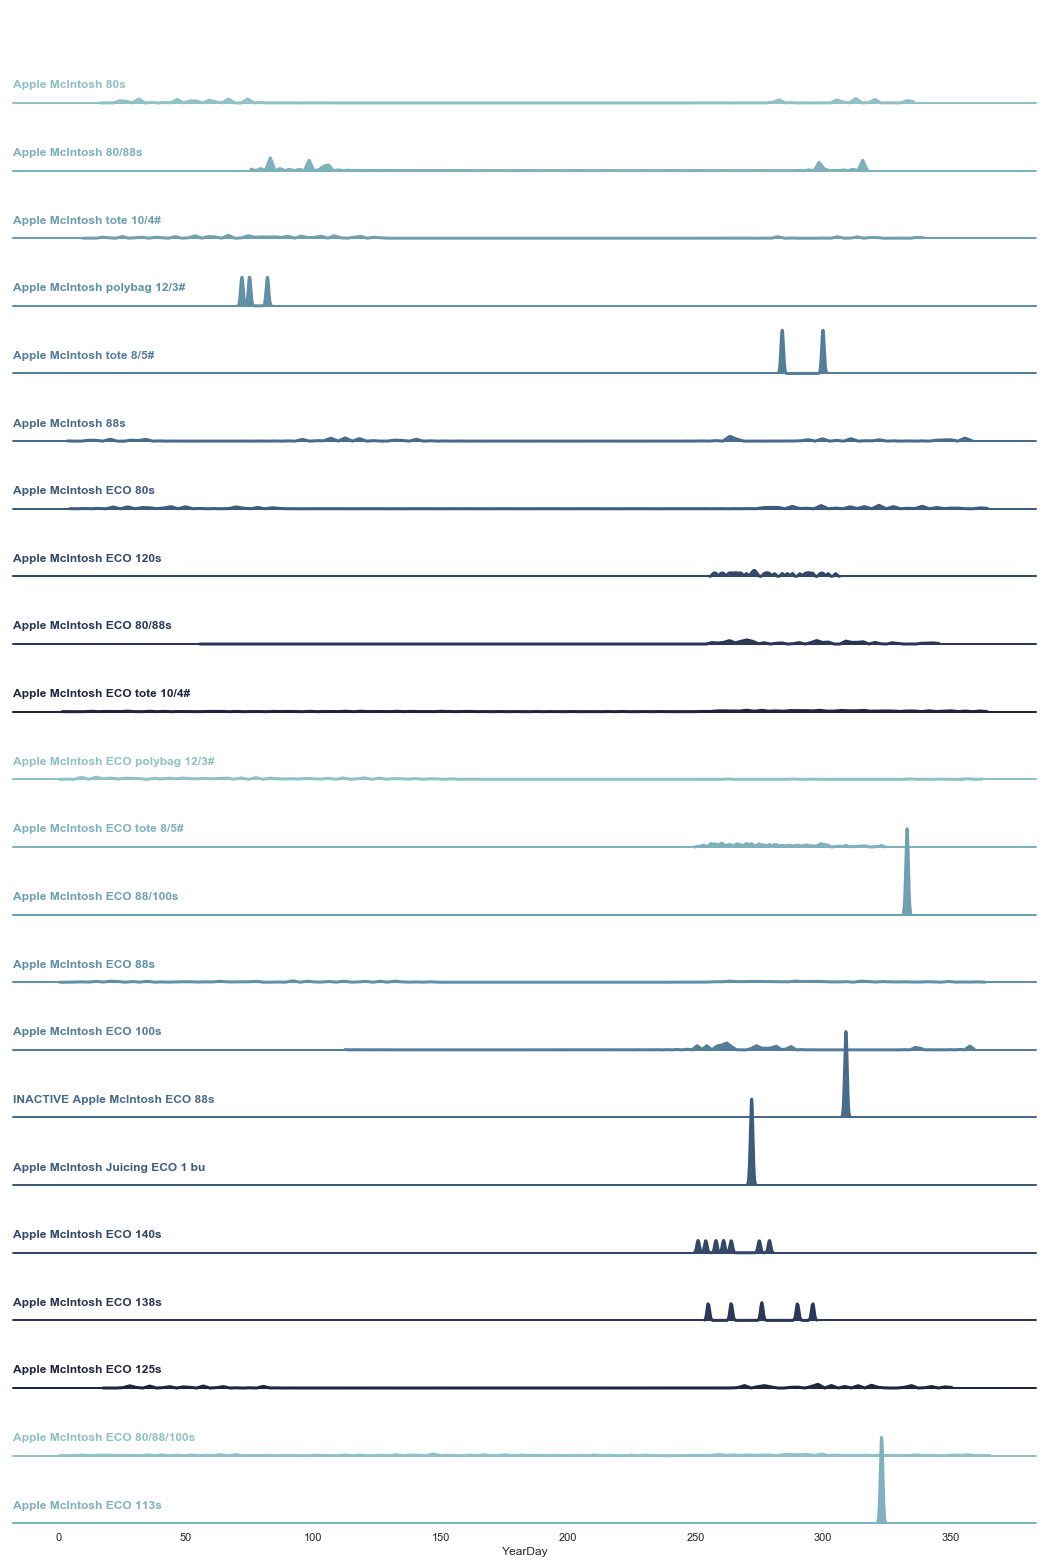

In [38]:
df = yearday.copy()
plot_purchase_density(df)

##  What's Next

* Compare against the broader Terminal Apple Market and how add-on costs relate to distance.



* Apply trend analysis to other Produce.

* Develop a model for isolating what the most profitable produce to farm are.

Thanks